# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage import io
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import imageio


We set the random seed so that the results don't vary drastically.

In [2]:
import tensorflow as tf
print(tf.__version__)

1.10.0


In [3]:
from tensorflow.python import keras
print(keras.__version__)

2.1.6-tf


In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('storage/train.csv').readlines())
val_doc = np.random.permutation(open('storage/val.csv').readlines())
batch_size = 32
num_classes =5
img_c=30 # image frames to be used 
img_height =128
img_width =128

In [6]:
train_doc = train_doc

In [7]:
val_doc = val_doc

In [8]:
len(train_doc)

100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_c #Setting image frame value from above as global #create a list of image numbers you want to use for a particular video
    x=img_idx
    y=img_height
    z=img_width
    while True:
        #print("inside whie")
        t = np.random.permutation(folder_list)
        num_batches = int((len(t))/batch_size) # calculate the number of batches
        #print("number of batches: "+str(num_batches))
        for batch in range(num_batches): # we iterate over the number of batches
            #print(batch)
            batch_data = np.zeros((batch_size+1,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size+1,5)) # batch_labels is the one hot representation of the output
            for folder in range(0,batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print(folder + (batch*batch_size))
                idc=0
                idx=0
                im=int(len(imgs))
                
                for item in range(im): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[idc]).astype(np.float32)
                    idc=idc+1
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (y, z))
                    
                    
                    norm_image = image/image.max()
                   
                    batch_data[folder,idx,:,:,0] = norm_image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = norm_image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = norm_image[:,:,2]#normalise and feed in the image
                    idx=idx+1
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) is not 0:
            #print("inside if")
            #print(len(t)%batch_size)
            total_processed = batch_size*num_batches
            left_out= int(len(t) - (batch_size*num_batches))
            #print(total_processed)
            #print(left_out)
            for i in range(total_processed,total_processed+left_out):
                #print(i)
                imgs = os.listdir(source_path+'/'+ t[i].split(';')[0])
                idc=0
                idx=0
                im=int(len(imgs))
                for item in range(im):
                    image = io.imread(source_path+'/'+ t[i].strip().split(';')[0]+'/'+imgs[idc]).astype(np.float32)
                    idc=idc+1
                    image = resize(image, (y, z))
                
                    #norm_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    norm_image = image/image.max()
                    #Under left out
                    batch_data[batch_size,idx,:,:,0] = norm_image[:,:,0]#normalise and feed in the image
                    batch_data[batch_size,idx,:,:,1] = norm_image[:,:,1]#normalise and feed in the image
                    batch_data[batch_size,idx,:,:,2] = norm_image[:,:,2]#normalise and feed in the image
                    idx=idx+1
                batch_labels[batch_size, int(t[i].strip().split(';')[2])] = 1
        
            yield batch_data, batch_labels

In [10]:
#gen = generator("storage/train", train_doc, batch_size)

In [11]:
#print(next(gen))

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'storage/train'
val_path = 'storage/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 2 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 100
# validation sequences = 100
# epochs = 2


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv3D

In [13]:

input_shape = np.zeros([img_c,img_height,img_width,3])
input_shape.shape


(30, 128, 128, 3)

In [14]:
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.applications import ResNet50


#write your model here
model = Sequential()

#1-Layer
model.add(Conv3D(16, (3,3,3),activation='relu',padding='same', input_shape=input_shape.shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

#2-Layer
model.add(Conv3D(32, (3,3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

#3-Layer
model.add(Conv3D(64, (3,3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

#Dense Layer
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


#Output Layer
model.add(Dense(num_classes, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:

optimiser = Adam(lr=0.1)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 128, 128, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 128, 128, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 64, 64, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64, 64, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 64, 64, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 64, 64, 32)    128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 32, 32, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


#EarlyStopping = EarlyStopping(monitor='val_loss', patience=21, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max', period=1)

LR = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.2,patience=10, cooldown =5,verbose=2, min_lr=0.001)# write the REducelronplateau code here

callbacks_list = [LR,checkpoint]


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(steps_per_epoch)
print(validation_steps)

20
20


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
model_training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
                    

Source path =  storage/val ; batch size = 32
Source path =  Epoch 1/2
storage/train ; batch size = 32
4/4 [==============================] - 35s 9s/step - loss: 2.1796 - categorical_accuracy: 0.2879 - val_loss: 10.4031 - val_categorical_accuracy: 0.2500

Epoch 00001: categorical_accuracy improved from -inf to 0.28788, saving model to model_init_2020-06-2817_09_12.684648/model-00001-2.17963-0.28788-10.40314-0.25000.h5
Epoch 2/2
4/4 [==============================] - 27s 7s/step - loss: 1.5416 - categorical_accuracy: 0.4697 - val_loss: 11.9458 - val_categorical_accuracy: 0.2424

Epoch 00002: categorical_accuracy improved from 0.28788 to 0.46970, saving model to model_init_2020-06-2817_09_12.684648/model-00002-1.54158-0.46970-11.94583-0.24242.h5


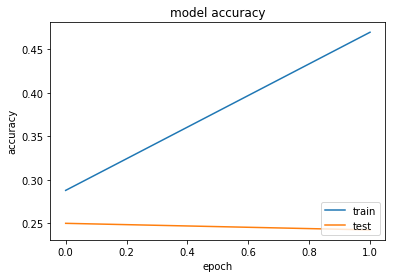

In [20]:
# visualise training history
plt.plot(model_training.history['categorical_accuracy'])
plt.plot(model_training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

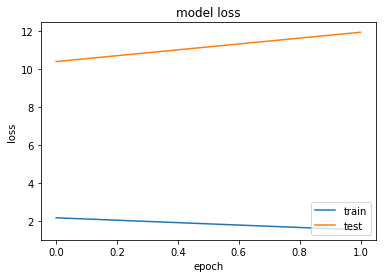

In [21]:
# visualise training history
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### CNN + RNN

In [19]:
# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet',include_top=False)
    
# freeze the layers in base model
#for layer in base_model.layers:
#   layer.trainable = False

split_at = 40
for layer in base_model.layers[:split_at]: layer.trainable = False
for layer in base_model.layers[split_at:]: layer.trainable = True
        
model = Sequential()


model.add(TimeDistributed(base_model, input_shape= input_shape.shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Flatten()))



model.add(GRU(64,activation='relu', return_sequences=False))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
  

In [20]:
# compile it
optimiser = Adam(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])

# summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 4, 4, 2048)    23587712  
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 32768)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                6303936   
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [22]:
# Training the newly added layers 

# flow data (in batches) from directories (while simultaneously preprocessing/augmenting
model_training = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    verbose=1)

Epoch 1/2
20/20 [==============================] - 44s 2s/step - loss: 2.3968 - acc: 0.1500 - val_loss: 1.3525 - val_acc: 0.3167
Epoch 2/2
20/20 [==============================] - 39s 2s/step - loss: 1.3954 - acc: 0.1917 - val_loss: 1.3477 - val_acc: 0.1750
